# Plot_MODFLOW_head_quickstart_2024.ipynb
ESCI 5331 - Fall 2024 gcng, 10/1/24

Plots data from MODFLOW-2005 binary head output file

In [2]:
import sys
import struct
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
#change directory to model_runs
os.chdir('C:/Users/huan1428/Documents/esci5331_hydro_modeling/assignment_5/model_runs/')

In [3]:
with open('avgd_k/test.lst', 'rb') as f:
    for line in f.readlines():
        line = str(line.strip())
        if 'TOTAL OUT =' in line: #find discharge line 
            temp = line.split(' ')
            temp = [x for x in temp if x.strip()] # remove blanks 
            vol_dis = float(temp[3])
            print(vol_dis)

                
        

FileNotFoundError: [Errno 2] No such file or directory: 'avgd_k/test.lst'

In [27]:
dis[0].strip()

b'MODFLOW-2005'

In [64]:
class HeadData():
    def __init__(self, a_info, kstp, kper,pertim,
        totim, label, ncol,nlay,ilay, time_unit, len_unit,
        delr, delc, top_elev, bottom_elev, vol_discharge,
        a_data,data):
        self.a_info = a_info
        self.kstp = kstp
        self.kper = kper
        self.pertim = pertim
        self.totim = totim 
        self.label = label
        self.ncol = ncol
        self.nlay = nlay
        self.ilay = ilay
        self.time_unit = time_unit
        self.len_unit = len_unit
        self.delr = delr
        self.delc = delc 
        self.domain_len = self.delc * ncol
        self.top_elev = top_elev
        self.bottom_elev = bottom_elev
        self.z = bottom_elev - top_elev
        self.dz = self.z/nlay
        self.a_data = a_data
        self.data = np.reshape(data, (nlay, ncol), order = 'C')
        self.data[self.data > 999] = np.nan 
        self.vol_discharge = vol_discharge #volumetric discharge
        self.darcy_flux = self.vol_discharge/(self.delc * self.delr) #darcy flux = Q / A 
        self.K = 0
    def set_K(self, K):
        self.K = K
def get_volume_discharge(lst_file):
        with open(lst_file, 'rb') as f:
            for line in f.readlines():
                line = str(line.strip())
                if 'TOTAL OUT =' in line: #find discharge line 
                    temp = line.split(' ')
                    temp = [x for x in temp if x.strip()] # remove blanks 
                    vol_dis = float(temp[3])
                    return(vol_dis)
                
def decode_head_file(path):
    nread = 0 #windows OS config
    head_file = f'{path}/testhead.dat'
    dis_file = f'{path}/test_1D.dis'
    lst_file = f'{path}/test.lst'
    def binbuild(nitems, nbytes, typecode, infile): #decode binary file and returns output as array
        outdata = []
        for i in range(nitems):
            outdata.append(struct.unpack(typecode, infile.read(nbytes)) )
        return np.squeeze(np.array(outdata))

    #decode head values and params 
    with open(head_file, 'rb') as fid: 
        a_info = binbuild( nitems=nread, nbytes=4, typecode='i', infile=fid )
        kstp = binbuild (nitems=1, nbytes=4, typecode='i', infile=fid ) # FIX THESE TO SCALAR
        kper = binbuild (nitems=1, nbytes=4, typecode='i', infile=fid ) # FIX THESE TO SCALAR
        pertim = binbuild (nitems=1, nbytes=4, typecode='f', infile=fid ) # FIX THESE TO SCALAR
        totim = binbuild (nitems=1, nbytes=4, typecode='f', infile=fid ) # FIX THESE TO SCALAR
        label = binbuild (nitems=16, nbytes=1, typecode='c', infile=fid ) # FIX TO CHAR ARRAY
        ncol = binbuild (nitems=1, nbytes=4, typecode='i', infile=fid ) # FIX THESE TO SCALAR
        nlay = binbuild (nitems=1, nbytes=4, typecode='i', infile=fid ) # FIX THESE TO SCALAR
        ilay = binbuild (nitems=1, nbytes=4, typecode='i', infile=fid ) # FIX THESE TO SCALAR
        a_info = binbuild( nitems=nread, nbytes=4, typecode='i', infile=fid )
        a_data = binbuild( nitems=nread, nbytes=4, typecode='i', infile=fid )
        nn = ncol*nlay
        data = binbuild (nitems=nn, nbytes=4, typecode='f', infile=fid)
    #get relevant model params + configs
    with open(dis_file, 'rb') as f:
        dis = f.readlines()
        dis_vars = dis[0].strip().split()
        time_unit_code = int(dis_vars[4])
        len_unit_code = int(dis_vars[5])
        delr= float(dis[2].strip().split()[1])
        delc = float(dis[3].strip().split()[1])
        top_elev = float(dis[4].strip().split()[1])
        bottom_elev = float(dis[-2].strip().split()[1])
    #get discharge 
    vol_dis = get_volume_discharge(lst_file)
    #set length and time units 
    match time_unit_code:
        case 0:
            time_unit = None
        case 1:
            time_unit = 'sec'
        case 2: 
            time_unit = 'min'
        case 3:
            time_unit = 'hr'
        case 4: 
            time_unit = 'd'
        case 5:
            time_unit = 'yr'
    match len_unit_code:
        case 0:
            len_unit = None
        case 1:
            len_unit = 'ft'
        case 2: 
            len_unit = 'm'
        case 3:
            len_unit = 'cm'

    head_data = HeadData( a_info, kstp, kper,pertim,
        totim, label, ncol,nlay,ilay, time_unit, len_unit,
        delr, delc, top_elev, bottom_elev,
        vol_dis,
        a_data,data)
    return head_data



In [71]:
#get data for all cases
head_data_2D = decode_head_file('./2d_flow')
head_data_2D_rech = decode_head_file('./2d_flow_recharge')

In [73]:
head_data_2D.set_K(6)
head_data_2D_rech.set_K(6)

In [66]:
head_data_1 = decode_head_file('./homogenous_k')
head_data_2 = decode_head_file('./avgd_k')
head_data_3 = decode_head_file('./2_layer_3_9')
head_data_4 = decode_head_file('./2_layer_9_3')

In [67]:
head_data_1.set_K(6)
head_data_2.set_K(4.5)
head_data_3.set_K(4.5)
head_data_4.set_K(4.5)

In [102]:
#plot data
def plot_head_data(head_data, #HeadData object from decode_head_data
                   fig_title = None,
                   savefig = None, #saved file name
                   is2D = False,#1D or 2D flow
                    ax = None): #ax obj for plotting multiple subplots 
    #get params
    domain_len = head_data.domain_len
    len_unit = head_data.len_unit
    time_unit = head_data.time_unit
    top_elev = head_data.top_elev
    bottom_elev = head_data.bottom_elev
    head_vals = head_data.data
    ncol = head_data.ncol
    nlay = head_data.nlay
    delc = head_data.delc
    dz = head_data.dz
    darcy_flux = np.round(head_data.darcy_flux, 5)
    z_vals = np.array([top_elev + dz*i for i in range(0, nlay)])
    K = head_data.K

    if is2D:
        x_vals = np.array([0 + delc * i for i in range(ncol)])
        X, Z = np.meshgrid(x_vals,z_vals)
        Vz, Vx = np.gradient(-head_vals) #calculate flow direction as 2 arrays of x gradient and z gradient 
        Vx = K * Vx
        Vz = K * Vz

    #plot figures
        # contour lines  
        fig, ax = plt.subplots(2,1)
        n_contours = 10
        x_step = ncol//n_contours
        z_step = nlay//n_contours 
        c1 = ax[0].contour(X, Z, head_vals, n_contours, linewidths=1)
        ax[0].set_xlabel(f'X [{len_unit}]')
        ax[0].set_ylabel(f'Z [{len_unit}]')
        cbar = fig.colorbar(c1, ax = ax[0])
        cbar.set_label(f'Head [{len_unit}]', fontsize=12)
        ax[0].quiver(X[::x_step,::z_step], Z[::x_step,::z_step], 
                     Vx[::x_step,::z_step], Vz[::x_step,::z_step], 
                     color='black',
                     alpha = 0.4,
                    #  scale=1, 
                     label = 'flow direction')  # flow arrows
        ax[0].legend()
        #continuous color map
        c2 = ax[1].imshow(head_vals, extent=[x_vals.min(), x_vals.max(), z_vals.min(), z_vals.max()], aspect='auto')
        cbar = fig.colorbar(c2, ax= ax[1])
        cbar.set_label(f'Head [{len_unit}]', fontsize=12)
        ax[1].set_xlabel(f'X [{len_unit}]')
        ax[1].set_ylabel(f'Z [{len_unit}]')
        

    else: #1D case 
        head_vals = head_vals.flatten()
        if ax != None: 
            sns.lineplot(x = head_vals, y = z_vals, ax = ax, label = f"{fig_title}, q = {darcy_flux} {len_unit}/{time_unit}", alpha = 0.4)
        else:
            fig, ax = plt.subplots()
            sns.lineplot(x = head_vals, y = z_vals)
        plt.xlabel(f"Head [{len_unit}]")
        plt.ylabel(f"Z [{len_unit}]")
    plt.title(f"{fig_title}, q = {darcy_flux} {len_unit}/{time_unit}")
    plt.tight_layout()
    if savefig != None:
        plt.savefig(f"{savefig}.png", bbox_inches = 'tight')

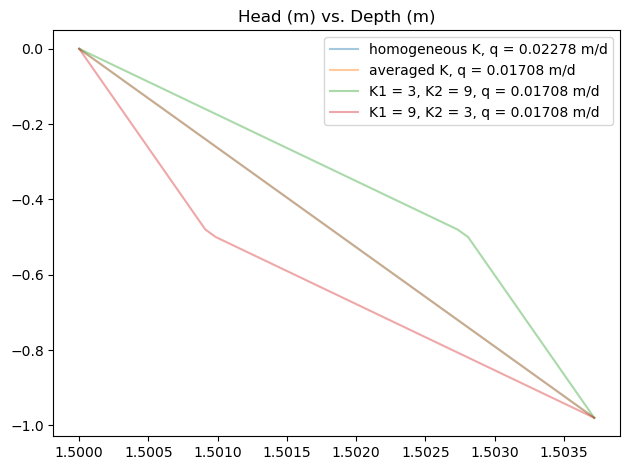

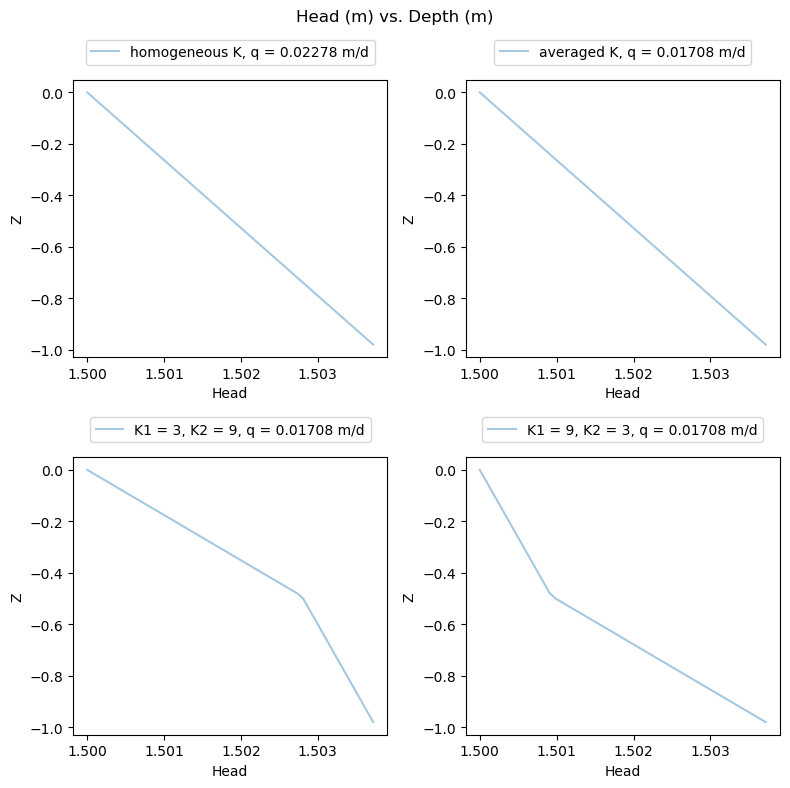

In [109]:
fig, ax = plt.subplots()
fig2, ax2 = plt.subplots(2,2, figsize = (8,8))
labels = ['homogeneous K', 'averaged K', 'K1 = 3, K2 = 9', 'K1 = 9, K2 = 3']
paths = ['homo_k', 'avg_k', '3_9', '9_3']
for i in range (1,5):
    subplot = ax2[(i -1) // 2, (i - 1) % 2]
    plot_head_data(eval(f'head_data_{i}'), labels[i-1], ax = ax)
    plot_head_data(eval(f'head_data_{i}'), labels[i-1], ax = subplot)
    subplot.set_xlabel("Head")
    subplot.set_ylabel("Z")
    subplot.set_title("")
    subplot.legend(bbox_to_anchor = (0.5, 1.1), loc = 'center')
ax.set_title("Head (m) vs. Depth (m)")
fig2.suptitle('Head (m) vs. Depth (m)')
fig.tight_layout()
fig2.tight_layout()
fig.savefig('hw5_1d_all_cases.png', bbox_inches = 'tight')
# fig2.savefig('hw5_1d_all_cases_separate.png', bbox_inches = 'tight')

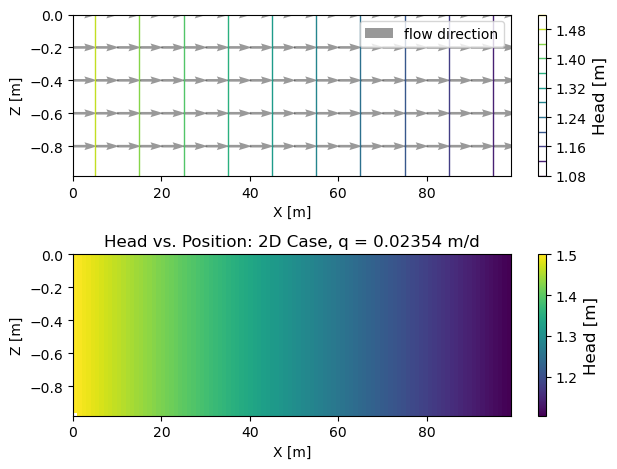

In [110]:
plot_head_data(head_data_2D, "Head vs. Position: 2D Case", 
               savefig = '2d_case', 
               is2D = True)

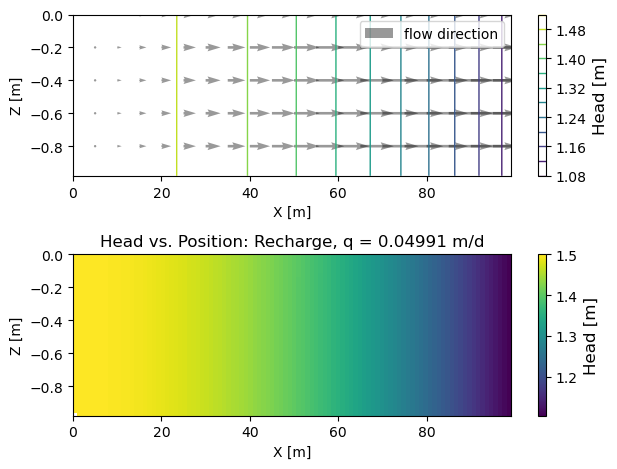

In [97]:
plot_head_data(head_data_2D_rech, "Head vs. Position: Recharge", savefig = '2d_recharge', is2D = True)